In this notebook we will build and apply a couple of different predictive models.  We will start by building a model based on a set of training data for the kinase ERK2 derived from the DUD-E dataset.  Once we have created this model, we will use it identify potential ERK2 inhibitors in a set of molecules from the ZINC database of commercially available molecules. 

First we will import the necessary Python libraries

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef,confusion_matrix, roc_auc_score
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools
from tqdm import tqdm

A few more imports and setttings to make our plots look as better

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
from IPython.display import SVG

We will be using chemical fingerprints as molecular descriptors.  In order to use these fingerprints in machine learning models, we need to convert them into Numpy arrays.  The function below accepts a molecule as input, calculates a fingerprint for that molecule, and coverts the fingerprint to a Numpy array.

In [3]:
def fp_as_array(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

Read in the input data.  This data contains the SMILES string for the molecule, a molecule id, and a variable indicating whether the molecule is active against the kinase ERK2.  

In [4]:
df = pd.read_csv("../data/dude_erk2_mk01.csv")

Let's look at the first few lines of the dataframe.

In [5]:
df.head()

,SMILES,Name,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


Let's see how many active and inactive molecules are in the dataframe.

In [6]:
print(df.is_active.value_counts())

0    4550
1      79
Name: is_active, dtype: int64


In order to perform calculations, we need to convert the molecules from SMILES to RDKit Molecule objects.  We can do this with the "MolFromSmiles" function.  We can use the list comprehension below to create a new column "Mol" in the dataframe with the RDKit molecule. 

In [7]:
df['Mol'] = [Chem.MolFromSmiles(x) for x in df.SMILES]

As mentioned above, we need to convert the molecules to a Numpy array representing the fingerprints in order to do the machine learning.  The list comprension below will return a list of Numpy arrays representing the fingerprints for the molecules. 

In [8]:
fp_list = [fp_as_array(x) for x in df.Mol]

When building a predictive model, it's always a goood idea to start by evaluating how good a model you can build with your training set. We will do this by performing 10 folds of cross validation with a Random Forest model trained  to classify molecules as active or inactive against ERK2.  For each cross validation fold, we will accumulate values for the Matthews Correlation Coefficient (MCC), a metric of model performance.  

In [9]:
mcc_list = []
for cycle in tqdm(range(0,10)):
    train_x, test_x, train_y, test_y = train_test_split(fp_list,df.is_active)
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(train_x,train_y)
    pred = rf.predict(test_x) 
    mcc_list.append(matthews_corrcoef(pred,test_y))

100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Generate a cumulative distribution plot (aka a histogram) showing the distribution of MCC values for the 10 folds of cross validation.  One typically considers values of MCC > 0.5 to indicate a reasonably good model. 

Let's reformat the data a bit so that we can look more closely at the predictions.

In [10]:
fp_list = [fp_as_array(x) for x in df.Mol]
fp_list = [([smiles,id],fp) for smiles,id,fp in zip(df.SMILES,df.Name,fp_list)]

Put the data into a dataframe.

In [11]:
pd.DataFrame(fp_list).head()

,0,1
0,[Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,[C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Keep track of detailed performance measure through mulitple folds of cross validation.  Note that this time we are saving the predictions and true values for each fold. 

In [12]:
mcc_list = []
detail_list = []
pred_list = []
for cycle in tqdm(range(0,10)):
    train_x, test_x, train_y, test_y = train_test_split(fp_list,df.is_active)
    train_name = [x[0] for x in train_x]
    train_fp = [x[1] for x in train_x]
    test_name = [x[0] for x in test_x]
    test_fp = [x[1] for x in test_x]
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(train_fp,train_y)
    pred = rf.predict(test_fp) 
    pred_list.append([pred,test_y])
    for name, pred_val, true_val in zip(test_name,pred,test_y):
        detail_list.append([cycle,name[0],name[1],pred_val,true_val])
    mcc_list.append(matthews_corrcoef(pred,test_y))

100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


For each of the cross validation folds we will calculate the confusion matrix that indicates the number of true positive, true negative, false positive and false negative values.  

In [13]:
row_list = []
for p,t in pred_list:
    row_list.append(confusion_matrix(p,t).flatten())
confusion_df = pd.DataFrame(row_list,columns="tn,fn,fp,tp".split(","))
confusion_df

,tn,fn,fp,tp
0,1144,4,0,10
1,1143,6,0,9
2,1148,0,0,10
3,1139,5,0,14
4,1142,6,0,10
5,1135,7,0,16
6,1139,6,0,13
7,1136,6,0,16
8,1141,3,0,14
9,1136,8,0,14


Looking at the table above, it's interesting that we have a few false negative predictions, but no false positive predictions. 

Let's make a plot of the distribution of MCCs across the folds of cross validation. 

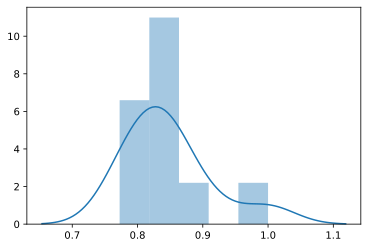

In [14]:
ax = sns.distplot(mcc_list)

Create a new dataframe containing the predictions for each molecule at each cross validation fold. 

In [15]:
detail_df = pd.DataFrame(detail_list,columns=["cycle","smiles","name","pred","true"])

In [16]:
detail_df.head()

,cycle,smiles,name,pred,true
0,0,CC(C)(C)[C@H](NC(=O)N1CCC[C@H](N)C1)C(=O)O,C42430310,0,0
1,0,c1ccc(c(c1)NC(=O)N[C@@H]2CCC[C@@H](C2)C(F)(F)F...,C45695601,0,0
2,0,COc1cccc(c1)/C=C/2\CNCC3=C2OC(=C([C@H]3c4cccc(...,C39326857,0,0
3,0,c1cc(sc1)C(=O)NNC(=O)CNC(=O)C23CC4CC(C2)CC(C4)C3,C05786360,0,0
4,0,Cc1cc(c(c(c1C=O)O)C/C=C(\C)/[C@@H](C[C@@]2([C@...,C13432937,0,0


As an exercise, create a new dataframe containing the average prediction for each molecule across the 10 folds of cross validation.

Look at the results from the first cross validation fold

In [17]:
detail_df.query("cycle == 0").pred.value_counts()

0    1148
1      10
Name: pred, dtype: int64

Take a look at the false negative predictions from the first cross validation fold (fold 0).

In [18]:
fn_smiles = [x for x in detail_df.query("pred == 0 and true == 1 and cycle == 0").smiles]
len(fn_smiles)

4

In order to be able to depict chemical structures we need to import the MolsToGridImage method from rdkit.Chem.Draw. 

In [19]:
from rdkit.Chem.Draw import MolsToGridImage

Draw the structures of the active molecules incorrectly classified as inactive (false negatives).

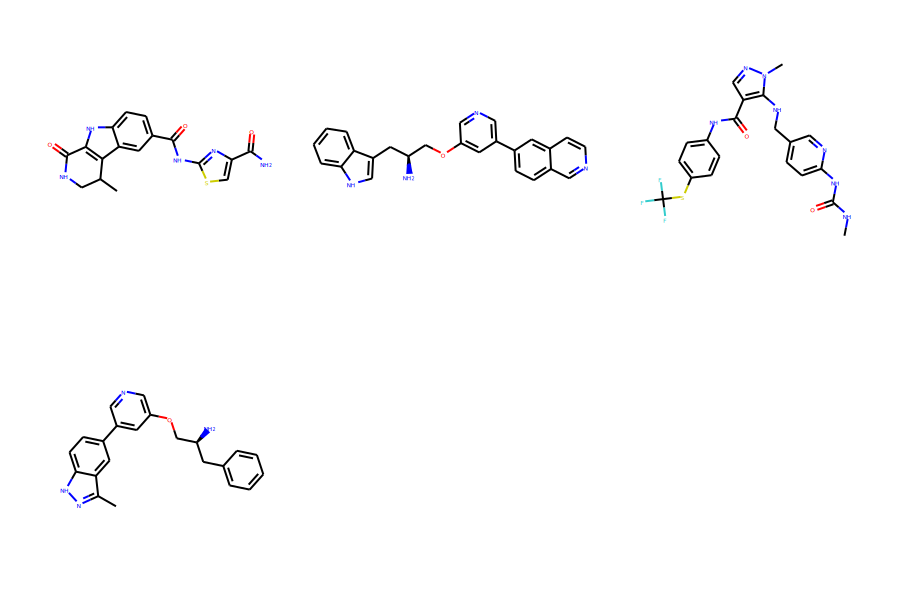

In [20]:
svg = MolsToGridImage([Chem.MolFromSmiles(x) for x in fn_smiles],molsPerRow=3,useSVG=True,subImgSize=(300, 300))
SVG(svg)

Now let's use all of the data to generate a model that we can use classify molecules from the ZINC database. First, we'll instantiate a new RandomForestClassifier object. 

In [21]:
model = RandomForestClassifier(n_estimators=100)

Now we'll train the model

In [22]:
model.fit([x[1] for x in fp_list],df.is_active)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

We are going to save our model to file on disk, in order to do this, we need to install the "joblib" Python library. 

In [23]:
!pip install joblib

Now we will save the model.

In [24]:
from joblib import dump, load
dump(model, 'mk01_model.joblib') 

['mk01_model.joblib']

Read in 100K molecules from the ZINC database. These molecules are in SMILES file, so we need to set the separator to be a space character. 

In [29]:
avail_df = pd.read_csv("../data/mk01/zinc_10k.smi",sep=" ",header=None)
avail_df.columns = ["SMILES","Name"]

In [30]:
avail_df.head()

,SMILES,Name
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101


Create a list of molecules from the 10K smiles in the dataframe.

In [31]:
mol_list = [Chem.MolFromSmiles(x) for x in avail_df.SMILES]

Create fingerprints from the molecules objects

In [32]:
avail_fp_list = [fp_as_array(x) for x in mol_list]

Make predictions using the fingerprints we just calculated. 

In [33]:
avail_pred = model.predict(avail_fp_list)

The predicted values are "1" if the molecule is predicted to be active and "0" if the molecule is predicted to be inactive. We can count the number of molecules predicted to be active by simply suming the predictions. 

In [34]:
sum(avail_pred)

0

It appears that none of the 10K molecules were predicted to be active.  Let's try another machine learning method and see if the results are different. This time we'll build a model using Logistic Regresssion.  We'll start by importing the necssary method from scikit-learn. 

In [35]:
from sklearn.linear_model import LogisticRegression

Next we'll create a LogisticRegression object

In [36]:
lr = LogisticRegression(solver='lbfgs')

We can train the Logistic Regression model in the same way we trained the Random Forest model.

In [37]:
lr.fit([x[1] for x in fp_list],df.is_active)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We can also generate predictions in same way. 

In [38]:
lr_pred = lr.predict(avail_fp_list)

Let's look at the predictions.

In [39]:
lr_pred

array([0, 0, 0, ..., 0, 0, 0])

Calculate the sum of the predictions to see which molecules were predicted as active. 

In [40]:
sum(lr_pred)

15

Add the Logistic Regression predictions back into our dataframe.

In [41]:
avail_df['LR'] = lr_pred

In [42]:
avail_df.head()

,SMILES,Name,LR
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,0
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,0
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,0
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,0
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,0


Check the number of active molecules in the dataframe.

In [43]:
avail_df.LR.value_counts()

0    9985
1      15
Name: LR, dtype: int64

Create a new dataframe with the activae molecules. 

In [44]:
avail_active = avail_df.query("LR == 1").copy()

In [45]:
avail_active.shape

(15, 3)

Add a molecule column to the dataframe

In [46]:
from rdkit.Chem import PandasTools

In [47]:
PandasTools.AddMoleculeColumnToFrame(avail_active,smilesCol="SMILES")

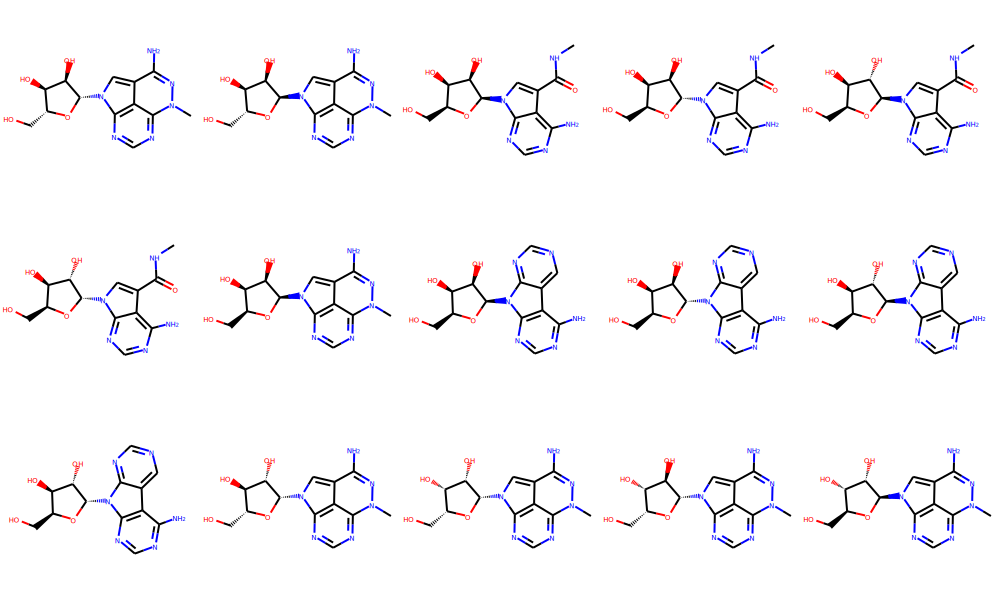

In [48]:
pic = MolsToGridImage([x for x in avail_active.ROMol],molsPerRow=5,useSVG=True)
SVG(pic)